# 5th-order passive RC low-pass filter
Last update: 12 Jan 2026

[How to design a 5th-order passive RC low-pass filter (500 kHz cutoff) in LTspice?](https://electronics.stackexchange.com/questions/761552/how-to-design-a-5th-order-passive-rc-low-pass-filter-500-khz-cutoff-in-ltspice)

Harshit Kumar Shakya asks: 
I am trying to simulate a 5th-order passive RC low-pass filter in LTspice.

My requirements:

- Cutoff frequency: 500 kHz
- Input frequency range: 30 kHz – 500 kHz
- Signal amplitude: 1.5 V p-p
- Only R and C components (no op-amps, no inductors)
- 5 RC sections in cascade

I tried using different R values (100 Ω to 1 kΩ) with 33 pF capacitors, but the cutoff is not sharp and each stage loads the next one. The output at 500 kHz barely drops.

My questions:

1. What R and C values should I use to get a real 500 kHz cutoff?
1. How can I reduce inter-stage loading in a fully passive RC cascade?
1. Is a 5-stage passive RC filter practical at 500 kHz, or do I need buffering?

Any guidance or example values would help.

---

Cascading five RC sections without isolation between the sections is an interesting filter design problem. The orginal poster (Harshit Kumar Shakya) didn't provide a schematic or state the desired topology, only that a fifth order filter was required. However most of those responding seem to be discussing a ladder topology in their answers. My proposed solution was developed using Python in a JupyterLab notebook. What you see below has been copied and pasted into the answer dialog box.    

**Question 1**
> What R and C values should I use to get a real 500 kHz cutoff?

Consider the schematic shown below, which I drew in LTSpice and copied the circuit here. All the component values are listed on the schematic as 1 for now. $V_1$ is the excitation and there is no source or load resistance terminating the filter, since none were specified. The input node is 1 and the output node is 6, as shown. 

Solution setps:
1. Draw the schematic of the proposed filter
1. Copy and paste the circuit's netlist into the Python code.
1. Use MNA to generate the network equations.
1. Symplify the circuit by letting $R_1=R_2=R_3=R_4=R_5=R$ and $C_1=C_2=C_3=C_4=C_5=C$
1. Substitute $R$ and $C$ into the network equations.
1. Solve for the node voltages and $V_1$ current.
1. Find the transfer function, $H(s)=\frac{v_6}{v_1}$.
1. Using the specified cut off frequency of 500kHz and chosing $C=500pF$, solve for $R$ such that $\vert H(s) \vert = 1/2$ at the cut off frequency.
1. Plot the frequncy response of the filter.
1. Check the solution with LTSpice.

## 1. Proposed Schematic
The filter to be analyzed is a five section $RC$ lader filter. $RC$ networks are often used in timing circuits, one pole filters or in combination with Op Amps. A five stage $RC$ laddar filter is not typically encountered in actual engineering practice. Other topologies such as a lattic could have been used, but I think they would have the same charasteric polyniminal. 

![schematic](5th_order_RC_filter.png)

The following Python libraries and modules are used in the analysis.

In [2]:
from sympy import *
import numpy as np
from tabulate import tabulate
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import SymMNA
from IPython.display import display, Markdown, Math, Latex
init_printing()
from scipy.optimize import fsolve

## 2. Circuit Net List
The netlist generated by LTSpice was copied into the code cell below.

In [3]:
net_list = '''
V1 1 0 1
R1 2 1 1
R2 3 2 1
R3 4 3 1
R4 5 4 1
R5 6 5 1
C1 2 0 1
C2 3 0 1
C3 4 0 1
C4 5 0 1
C5 6 0 1
'''

## 3. Use MNA to generate the network equations.
The [Modified Nodal Analysis](https://en.wikipedia.org/wiki/Modified_nodal_analysis) (MNA) procedure will be used to generate the newtork equations from the schematic's netlist. The procedure is implemented in Python and the function `SymMNA.smna(net_list)` returns the network equations as matricies along with a report and two Pandas data frames. The Python module available on GitHub at [SymMNA](https://github.com/Tiburonboy/SymMNA).

In [4]:
report, network_df, i_unk_df, A, X, Z = SymMNA.smna(net_list)

The code below assembles the network equations from the MNA matrices and displays the equations.

In [5]:
# Put matrices into SymPy 
X = Matrix(X)
Z = Matrix(Z)

NE_sym = Eq(A*X,Z)

# the free symbols are entered as SymPy variables and the element values are put into a dictionary.
var(str(NE_sym.free_symbols).replace('{','').replace('}',''))

# the element values are loaded into a dictionary
element_values = SymMNA.get_part_values(network_df) # get element vales from netlist dataframe

# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE_sym.rhs[i]),latex(NE_sym.lhs[i]))
Markdown(temp)

$0 = I_{V1} + \frac{v_{1}}{R_{1}} - \frac{v_{2}}{R_{1}}$<br>$0 = v_{2} \left(C_{1} s + \frac{1}{R_{2}} + \frac{1}{R_{1}}\right) - \frac{v_{3}}{R_{2}} - \frac{v_{1}}{R_{1}}$<br>$0 = v_{3} \left(C_{2} s + \frac{1}{R_{3}} + \frac{1}{R_{2}}\right) - \frac{v_{4}}{R_{3}} - \frac{v_{2}}{R_{2}}$<br>$0 = v_{4} \left(C_{3} s + \frac{1}{R_{4}} + \frac{1}{R_{3}}\right) - \frac{v_{5}}{R_{4}} - \frac{v_{3}}{R_{3}}$<br>$0 = v_{5} \left(C_{4} s + \frac{1}{R_{5}} + \frac{1}{R_{4}}\right) - \frac{v_{6}}{R_{5}} - \frac{v_{4}}{R_{4}}$<br>$0 = v_{6} \left(C_{5} s + \frac{1}{R_{5}}\right) - \frac{v_{5}}{R_{5}}$<br>$V_{1} = v_{1}$<br>

The network equations for the netlist can be solved symbolically and the node voltages and dependent currents are displayed using symbolic notation. 

## 4. Symplify the circuit by letting $R_1=R_2=R_3=R_4=R_5=R$ and $C_1=C_2=C_3=C_4=C_5=C$

The propsed solution would be much different if all the $R's$ and $C's$ were required to have different values. 

In [6]:
R, C = symbols('R C')

## 5. Substitute $R$ and $C$ into the network equations.

In [7]:
NE_sym = NE_sym.subs({C1:C, C2:C, C3:C, C4:C, C5:C, R1:R, R2:R, R3:R, R4:R, R5:R})

In [8]:
# display the equations
temp = ''
for i in range(shape(NE_sym.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE_sym.rhs[i]),latex(NE_sym.lhs[i]))
Markdown(temp)

$0 = I_{V1} + \frac{v_{1}}{R} - \frac{v_{2}}{R}$<br>$0 = v_{2} \left(C s + \frac{2}{R}\right) - \frac{v_{1}}{R} - \frac{v_{3}}{R}$<br>$0 = v_{3} \left(C s + \frac{2}{R}\right) - \frac{v_{2}}{R} - \frac{v_{4}}{R}$<br>$0 = v_{4} \left(C s + \frac{2}{R}\right) - \frac{v_{3}}{R} - \frac{v_{5}}{R}$<br>$0 = v_{5} \left(C s + \frac{2}{R}\right) - \frac{v_{4}}{R} - \frac{v_{6}}{R}$<br>$0 = v_{6} \left(C s + \frac{1}{R}\right) - \frac{v_{5}}{R}$<br>$V_{1} = v_{1}$<br>

## 6. Solve for the node voltages and $V_1$ current.

In [9]:
%%time
U_sym = solve(NE_sym,X)

CPU times: user 80.1 ms, sys: 0 ns, total: 80.1 ms
Wall time: 79.8 ms


In [10]:
temp = ''
for i in U_sym.keys():
    temp += '${:s} = {:s}$<br>'.format(latex(i),latex(U_sym[i]))

Markdown(temp)

$v_{1} = V_{1}$<br>$v_{2} = \frac{C^{4} R^{4} V_{1} s^{4} + 7 C^{3} R^{3} V_{1} s^{3} + 15 C^{2} R^{2} V_{1} s^{2} + 10 C R V_{1} s + V_{1}}{C^{5} R^{5} s^{5} + 9 C^{4} R^{4} s^{4} + 28 C^{3} R^{3} s^{3} + 35 C^{2} R^{2} s^{2} + 15 C R s + 1}$<br>$v_{3} = \frac{C^{3} R^{3} V_{1} s^{3} + 5 C^{2} R^{2} V_{1} s^{2} + 6 C R V_{1} s + V_{1}}{C^{5} R^{5} s^{5} + 9 C^{4} R^{4} s^{4} + 28 C^{3} R^{3} s^{3} + 35 C^{2} R^{2} s^{2} + 15 C R s + 1}$<br>$v_{4} = \frac{C^{2} R^{2} V_{1} s^{2} + 3 C R V_{1} s + V_{1}}{C^{5} R^{5} s^{5} + 9 C^{4} R^{4} s^{4} + 28 C^{3} R^{3} s^{3} + 35 C^{2} R^{2} s^{2} + 15 C R s + 1}$<br>$v_{5} = \frac{C R V_{1} s + V_{1}}{C^{5} R^{5} s^{5} + 9 C^{4} R^{4} s^{4} + 28 C^{3} R^{3} s^{3} + 35 C^{2} R^{2} s^{2} + 15 C R s + 1}$<br>$v_{6} = \frac{V_{1}}{C^{5} R^{5} s^{5} + 9 C^{4} R^{4} s^{4} + 28 C^{3} R^{3} s^{3} + 35 C^{2} R^{2} s^{2} + 15 C R s + 1}$<br>$I_{V1} = \frac{- C^{5} R^{4} V_{1} s^{5} - 8 C^{4} R^{3} V_{1} s^{4} - 21 C^{3} R^{2} V_{1} s^{3} - 20 C^{2} R V_{1} s^{2} - 5 C V_{1} s}{C^{5} R^{5} s^{5} + 9 C^{4} R^{4} s^{4} + 28 C^{3} R^{3} s^{3} + 35 C^{2} R^{2} s^{2} + 15 C R s + 1}$<br>

comments ...

## 7. Find the transfer function, $H(s)=\frac{v_6}{v_1}$.

In [11]:
H_sym = U_sym[v6]/U_sym[v1]
Markdown('$H(s)={:s}$'.format(latex(H_sym)))

$H(s)=\frac{1}{C^{5} R^{5} s^{5} + 9 C^{4} R^{4} s^{4} + 28 C^{3} R^{3} s^{3} + 35 C^{2} R^{2} s^{2} + 15 C R s + 1}$

comments ...

In [12]:
H_sym_num, H_sym_denom = fraction(H_sym) #returns numerator and denominator

The denominator polynomial of $H(s)$ is called the characteristic polynomial. The roots of the denominator, also called poles of the system. The denominator polynomial is:

In [13]:
Markdown('$D(s)={:s}$'.format(latex(H_sym_denom)))

$D(s)=C^{5} R^{5} s^{5} + 9 C^{4} R^{4} s^{4} + 28 C^{3} R^{3} s^{3} + 35 C^{2} R^{2} s^{2} + 15 C R s + 1$

## 8. Find the Mag of transfer function
Using the specified cut off frequency of 500kHz and chosing $C=47pF$, solve for $R$ such that $\vert H(s) \vert = \frac {1}{\sqrt{2}}$ at the cut off frequency.

In [14]:
w_sym = symbols('w_sym')

In [15]:
H_sym_denom_jw = H_sym_denom.subs({s:1j*w_sym})
Markdown('${:s}$'.format(latex(H_sym_denom_jw)))

$1.0 i C^{5} R^{5} w_{sym}^{5} + 9.0 C^{4} R^{4} w_{sym}^{4} - 28.0 i C^{3} R^{3} w_{sym}^{3} - 35.0 C^{2} R^{2} w_{sym}^{2} + 15.0 i C R w_{sym} + 1$

comments ...

In [16]:
f_3dB = 500e3

w_value = 2*np.pi*f_3dB
print(f'cut off frequency: {w_value:,.2f} radians/sec')

cut off frequency: 3,141,592.65 radians/sec


comments ...

In [17]:
C_value = 47e-12
Markdown('${:s}$'.format(latex(H_sym_denom_jw.subs({C:C_value,w_sym:w_value}))))

$7.01840867492181 \cdot 10^{-20} i R^{5} + 4.27792761671303 \cdot 10^{-15} R^{4} - 9.01366105858055 \cdot 10^{-11} i R^{3} - 7.63068464270224 \cdot 10^{-7} R^{2} + 0.0022148228207808 i R + 1$

Comments ...

In [18]:
f = lambdify(R, abs(H_sym_denom_jw.subs({C:C_value,w_sym:w_value}))-sqrt(2), 'numpy')

comments ...

In [19]:
R_value = fsolve(f,1)[0]
print(f'resistor value: {R_value:.2f} ohms')

resistor value: 539.54 ohms


comments ...

In [20]:
NE = NE_sym.subs({R:R_value, C:C_value})

temp = ''
for i in range(shape(NE.lhs)[0]):
    temp += '${:s} = {:s}$<br>'.format(latex(NE.rhs[i]),latex(NE.lhs[i]))

Markdown(temp)

$0 = I_{V1} + 0.00185343659126971 v_{1} - 0.00185343659126971 v_{2}$<br>$0 = - 0.00185343659126971 v_{1} + v_{2} \cdot \left(4.7 \cdot 10^{-11} s + 0.00370687318253942\right) - 0.00185343659126971 v_{3}$<br>$0 = - 0.00185343659126971 v_{2} + v_{3} \cdot \left(4.7 \cdot 10^{-11} s + 0.00370687318253942\right) - 0.00185343659126971 v_{4}$<br>$0 = - 0.00185343659126971 v_{3} + v_{4} \cdot \left(4.7 \cdot 10^{-11} s + 0.00370687318253942\right) - 0.00185343659126971 v_{5}$<br>$0 = - 0.00185343659126971 v_{4} + v_{5} \cdot \left(4.7 \cdot 10^{-11} s + 0.00370687318253942\right) - 0.00185343659126971 v_{6}$<br>$0 = - 0.00185343659126971 v_{5} + v_{6} \cdot \left(4.7 \cdot 10^{-11} s + 0.00185343659126971\right)$<br>$V_{1} = v_{1}$<br>

Solve for voltages and currents.

In [21]:
U = solve(NE,X)

Transfer function ...

In [22]:
H = (U[v6]/U[v1])
Markdown('$H(s)={:s}$'.format(latex(H)))

$H(s)=\frac{2.18720083944673 \cdot 10^{71}}{2.29345007 \cdot 10^{33} s^{5} + 8.13976138721121 \cdot 10^{41} s^{4} + 9.98635661416841 \cdot 10^{49} s^{3} + 4.92262733036383 \cdot 10^{57} s^{2} + 8.31955406013434 \cdot 10^{64} s + 2.18720083944673 \cdot 10^{71}}$

## 9. Plot the frequncy response of the filter.
Using SciPy bode function ....

In [23]:
num, denom = fraction(H) #returns numerator and denominator

# convert symbolic to numpy polynomial
a = np.array(Poly(num, s).all_coeffs(), dtype=float)
b = np.array(Poly(denom, s).all_coeffs(), dtype=float)

x = np.logspace(3, 6, 2000, endpoint=False)*2*np.pi
w, mag, phase = signal.bode((a, b), w=x) # returns: rad/s, mag in dB, phase in deg

Plot the results.  

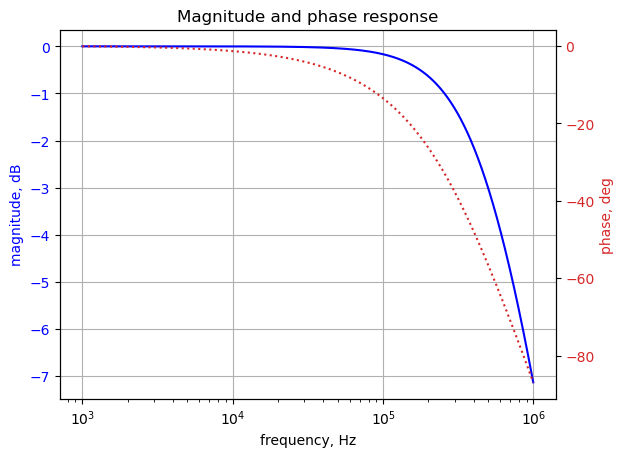

In [24]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('magnitude, dB',color='b')
ax1.set_xlabel('frequency, Hz')

plt.semilogx(w/(2*np.pi), mag,'-b')    # Bode magnitude plot

ax1.tick_params(axis='y', labelcolor='b')
plt.grid()

# instantiate a second y-axes that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'

plt.semilogx(w/(2*np.pi), phase,':',color='tab:red')  # Bode phase plot

ax2.set_ylabel('phase, deg',color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Magnitude and phase response')
plt.show()

comments ...

- The filter's performance is poor, as measured by the width of the transition band.
- only meeting the cut off frequency and N=5 requirements
- You would get lots of "why" questions if a _five stage $RC$ no op amp filter_ was presented at a design review. 
- Since you didn't describe the application, your question seems more like a interesting puzzel, and not a real world design problem.

## 10. Check the solution with LTSpice.

# Answer to question 2.
>How can I reduce inter-stage loading in a fully passive RC cascade?

Given that one of your requirements is "no op-amps", isolating one $RC$ stage from the next is somewhat like asking, "How can I isolate the stages with using any isolation". I think the only hope is to proceed with a $RC$ synthesis procedure that accounts for whats happening from one stage to the next. In otherwords, don't look at each $RC$ independently, but all of them as a system.  

# Answer to question 3.
>Is a 5-stage passive RC filter practical at 500 kHz, or do I need buffering?

Your filter specification is missing the stopband attenuation requirement. Without that piece of information, along with the load and source impedance, it's hard to tell if all your requirements are realizable. Limiting the components to $R's$ and $C's$ only, means the network can only have negative real poles and the transition from pass to stop band will be gradual, relative to more traditional filter types. In fact, any of the canonical filter types having complex valued poles are out of bounds.

You stated that the input frequency range is 30 kHz to 500 kHz, but only specified a low pass filter with a cut off at 500 kHz. What filter will implement the 30 kHz corner? Maybe you need a band pass filter?

## Finally you asked:

>Any guidance or example values would help.

I think you should start your question by providing some context and a description of the application. Your $RC$ only, N=5 and no Op Amp constraints are unusual.  

The JupyterLab notebook used to analyze the $RC$ filter is available on GitHub at ]()